Analyzing cosmological simulations
==================================

# Step 0: getting the data
Today we will use the data from the TNG100-3 simulation. You can download them using:

In [ ]:
!wget https://datashare.mpcdf.mpg.de/s/ouBQP25OEh7tk55/download -O tng100-3.tar.gz
!mkdir tng100-3
!tar -xzf tng100-3.tar.gz -C tng100-3

--2025-07-30 07:26:54--  https://datashare.mpcdf.mpg.de/s/ZiN9qrAQNjYqzuF/download
Resolving datashare.mpcdf.mpg.de (datashare.mpcdf.mpg.de)... 130.183.207.3
Connecting to datashare.mpcdf.mpg.de (datashare.mpcdf.mpg.de)|130.183.207.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6247484091 (5.8G) [application/gzip]
Saving to: ‘tng300-3.tar.gz’

tng300-3.tar.gz     100%[===================>]   5.82G  15.8MB/s    in 6m 24s  

2025-07-30 07:33:20 (15.5 MB/s) - ‘tng300-3.tar.gz’ saved [6247484091/6247484091]



In [ ]:
# smaller simulation
!wget https://datashare.mpcdf.mpg.de/s/uYAfv1BYL3ffEf4/download -O small_sim_snap013.tar.gz
!mkdir small_sim
!tar -xzf small_sim_snap013.tar.gz -C small_sim

--2025-07-30 06:37:11--  https://datashare.mpcdf.mpg.de/s/uYAfv1BYL3ffEf4/download
Resolving datashare.mpcdf.mpg.de (datashare.mpcdf.mpg.de)... 130.183.207.3
Connecting to datashare.mpcdf.mpg.de (datashare.mpcdf.mpg.de)|130.183.207.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 268939808 (256M) [application/gzip]
Saving to: ‘small_sim_snap013.tar.gz’

small_sim_snap013.t 100%[===================>] 256.48M  15.5MB/s    in 18s     

2025-07-30 06:37:29 (14.4 MB/s) - ‘small_sim_snap013.tar.gz’ saved [268939808/268939808]



# What is a cosmological simulation?
In astrophysics, numerical simulations are a fundamental tool. There are two main reasons why:
* stars, planets, galaxies, ... are extremely complex systems, so even if we understand basic physical laws, it's impossible to predict how these interact with pen and paper
* science is based on a cycle of observation-hypothesis-experiments, but in astrophysics we can not manipulate the Universe to make experiments. Therefore, we need to turn to virtual universes (simulations) to make virtual experiments

These simulations combine different ingredients:
* gravity
* fluid dynamics
* chemistry 
* (sometimes) radiation
* (sometimes) magnetic fields

Then, starting from our best guess on the conditions of the Universe after the Big Bang, we evolve these synthetic universes until today and use them to run experiments, understand observations, etc.

Let's start with some visualizations to get an idea of what we are dealing with. For example, the distribution of matter in one of these simulations looks like this:

![cosmic_web_millenium](https://astrobites.org/wp-content/uploads/2012/07/cosmic-web.jpg)

If we start to zoom in, we can see individual galaxies, for example here;

![galaxy](tng_visual.png)

# The AREPO code
There are many different simulations codes, and each one of them works in a different way and saves the data in different formats. 

For this tutorial, we will work with a simulation produced with a code called AREPO. Let's familiarize with it a bit

## Types of resolution elements

### Fliuds (gas)

AREPO uses a 3D mesh to discretize fluids. For example, the continuous fluid on the left, can be discretized using a Cartesian mesh (right) where each cell represents the fluid in it.  

![mesh](mesh.png)

AREPO is unique because it uses a Voronoi mesh, a much more general and adaptive mesh with respect to the Cartesian one.

![voronoi](voronoi.png)

Even better, this mesh adapts to the gas flow, so that it's resolution is better where there is more 'action'

![khi](khi_arepo.png)
![gal](gal_arepo.png)

Each one of the cells contains a single value for each of the quantity describing the fluid. For example, it might contain: density, velocity and temperature. But only one value for each of these is allowed in each cell.

### Dark Matter
Dark Matter is a mysterious substance that makes up 80% of the mass in the Universe. It seems to interact only through gravity (so, no light, no electro-magnetic fields, etc.). Because of this, it is NOT a fluid. AREPO represents it using particles. These are not fundamental particles, but rather represent large "pieces" of the Universe. Often these "pieces" are millions of time larger than the solar system, but still tiny compared to (most) galaxies. These particles have, by construction, all the same mass. 

### Stars
Stars are also represented using particles. In reality, stars are large spheres of self-gravitating, nuclear burning gas. In fact, we can use CFD codes (including AREPO) to simulate them. But they are so tiny compared to a galaxy or the entire Universe, that they are often represented by particles that interact through gravity only. (Stellar collision are so incredibly rare that they do not matter at the scales of these simulations)

### Black hole, tracers, low-res particles, ...
There are many more "things" that can be simulated in AREPO. For today, we are going to ignore them. 

## Data format
AREPO outputs are most often in the [HDF5 format](https://www.hdfgroup.org/), but can also be in 2 other legacy format. For today, we will only use the HDF5 format.

AREPO, like most simulations of structure formation, has two main types of outputs (but there can be many more): 
* **snapshots**: full outputs storing the individual resolution elements of the simulation: (Voronoi) mesh, dark matter partcles, stellar particles, ...
* **groups catalog**: collection of structures found in the simulation


### Snapshot
A snapshot, in practice, is an HDF5 file with different HDF5 Groups. One group, called `Header` contains meta-data about the file itself and the simulation that produced it. Another one (`Config`) contains the setup of AREPO used for the siulation. Each other group contains the data concerning one type of resolution element. These groups are named `PartTypeN`, with `N` starting from 0 and increasing. The table below shows what each type `N` represents.
  | Type | Meaning     |
  | ---- | ----------- |
  | 0    | Gas         |
  | 1    | Dark Matter |
  | 4    | Stars       |
  | 5    | Black holes |

Each particle type has a number of fields associated, that changes for each type. We will see below how to find out which one are available.
- If all particles of one type have the same mass, this is not saved in the fields, but rather in the `MassTable` attribute of the `Header` group

### Group catalogs
The group catalogs contain two types of structures: Groups and Subhalos.
* **Groups** represent collections of particles that are close to each other, but there is no guarantee that they are physically associated. 
* **Subhaloes** represent collections of particles that are physically bound to each other. We usually think of these as galaxies.
In both cases, the halo catalogs contain only the _summary properties_ of these collections. For example, the _total_ mass of the subhalo, the average temperature, etc.

### File chunks
For efficiency reasons, a single snapshot or group catalog is often split into multiple _chunks_ that must be combined to obtain the full information. For today, the details are not important because we will use a library that does this for us.


### More info
- AREPO wiki (for public version only, but almost identical for the private version as well): https://gitlab.mpcdf.mpg.de/vrs/arepo/-/wikis/userguide/snapshotformat
- IllustrisTNG data specification: https://www.tng-project.org/data/docs/specifications/
- Thesan data specification: https://thesan-project.com/data.html

## Libraries
There are a few python libraries that can simplify the task of loading these data. For today's tutorial, we will use the [illustris_python](https://github.com/illustristng/illustris_python) library. You can install it in the following way:

In [ ]:
!pip install --upgrade "git+https://github.com/illustristng/illustris_python.git"

## Additional resources
- AREPO wiki: https://gitlab.mpcdf.mpg.de/vrs/arepo/-/wikis/home
- code paper: https://arxiv.org/abs/0901.4107
- further development paper: https://arxiv.org/pdf/1503.00562
- RT solver paper: https://academic.oup.com/mnras/article/485/1/117/5303742
- introduction to the code (by me):  https://datashare.mpcdf.mpg.de/s/TmjvOoDm4Nm4Pnv

# Step 1: simple data exploration
Let's start by simply checking the data we have available.

In [ ]:
import h5py
import numpy as np

with h5py.File(f'tng100-3/output/snapdir_098/snap_098.0.hdf5', 'r') as snapfile:
    
    print("HDF5 groups available:")
    for group_name in snapfile.keys():
        print(f" - {group_name}")
    print()

    #print the attributes of the 'Header' group
    header = snapfile['Header']
    print("Attributes in the Header group:")
    for attr_name, attr_value in header.attrs.items():
        print(f" - {attr_name}: {attr_value}")
    print()

    #print the datasets available for each particle type:")
    for part_type in snapfile.keys():
        if part_type.startswith('PartType'):
            print(f"Particle type: {part_type}")
            part_data = snapfile[part_type]
            for dataset_name in part_data.keys():
                print(f" - {dataset_name}: shape {part_data[dataset_name].shape}, dtype {part_data[dataset_name].dtype}")
            print()

HDF5 groups available:
 - Config
 - Header
 - Parameters
 - PartType0
 - PartType1
 - PartType4
 - PartType5

Attributes in the Header group:
 - BoxSize: 75000.0
 - Composition_vector_length: 0
 - Flag_Cooling: 1
 - Flag_DoublePrecision: 0
 - Flag_Feedback: 1
 - Flag_Metals: 0
 - Flag_Sfr: 1
 - Flag_StellarAge: 0
 - Git_commit: b'd203ec8b07c7e2bdda5f608aa0babea46d603699'
 - Git_date: b'Thu Apr 7 14:14:27 2016 +0200'
 - HubbleParam: 0.6774
 - MassTable: [0.         0.03235675 0.         0.00302063 0.         0.        ]
 - NumFilesPerSnapshot: 7
 - NumPart_ThisFile: [12687804 13349540        0        0   329031     4397]
 - NumPart_Total: [88953586 94196375        0        0  2234312    30546]
 - NumPart_Total_HighWord: [0 0 0 0 0 0]
 - Omega0: 0.3089
 - OmegaBaryon: 0.0486
 - OmegaLambda: 0.6911
 - Redshift: 0.009521666967944764
 - Time: 0.99056814006128
 - UnitLength_in_cm: 3.085678e+21
 - UnitMass_in_g: 1.989e+43
 - UnitVelocity_in_cm_per_s: 100000.0

Particle type: PartType0
 - Coor

In [ ]:
with h5py.File('tng100-3/output/snapdir_098/snap_098.0.hdf5', 'r') as snapfile:
    print(snapfile['PartType0/Coordinates'][:10])

[[  859.0177  26337.934   18300.203  ]
 [  860.2749  26333.615   18303.49   ]
 [  855.16754 26336.504   18301.51   ]
 [  860.8275  26334.652   18298.73   ]
 [  863.92334 26340.432   18312.426  ]
 [  864.62616 26338.238   18308.762  ]
 [  848.9527  26347.947   18303.516  ]
 [  856.10535 26333.023   18295.262  ]
 [  852.23474 26329.668   18299.854  ]
 [  857.6006  26337.043   18320.324  ]]


## File chunks and illustris_python
As mentioned, snapshot files are split in chunks, each one with (potentially) a different number of particles.

In [ ]:
with h5py.File('tng100-3/output/snapdir_098/snap_098.0.hdf5', 'r') as snapfile:
    Nfiles = snapfile['Header'].attrs['NumFilesPerSnapshot']

for ifile in range(Nfiles):
    with h5py.File(f'tng100-3/output/snapdir_098/snap_098.{ifile}.hdf5', 'r') as snapfile:
        print(f"File {ifile}:", snapfile['Header'].attrs['NumPart_ThisFile'])

File 0: [12687804 13349540        0        0   329031     4397]
File 1: [12659106 13531482        0        0   320019     4283]
File 2: [12726033 13457741        0        0   315224     4231]
File 3: [12699775 13468331        0        0   304919     4395]
File 4: [12739698 13509973        0        0   307796     4370]
File 5: [12707571 13482998        0        0   350352     4542]
File 6: [12733599 13396310        0        0   306971     4328]


So, if we want to load all gas particles, we have to explicitly loop over all files. For example:

In [ ]:
gas_positions = []

for ifile in range(Nfiles):
    with h5py.File(f'tng100-3/output/snapdir_098/snap_098.{ifile}.hdf5', 'r') as snapfile:
        gas_positions.append(snapfile['PartType0/Coordinates'][:])

Or, we can use the `illustris_python` to do this for us.

In [2]:
import illustris_python as il
?il.snapshot.loadSubset

Signature:
il.snapshot.loadSubset(
    basePath,
    snapNum,
    partType,
    fields=None,
    subset=None,
    mdi=None,
    sq=True,
    float32=False,
)
Docstring:
Load a subset of fields for all particles/cells of a given partType.
If offset and length specified, load only that subset of the partType.
If mdi is specified, must be a list of integers of the same length as fields,
giving for each field the multi-dimensional index (on the second dimension) to load.
  For example, fields=['Coordinates', 'Masses'] and mdi=[1, None] returns a 1D array
  of y-Coordinates only, together with Masses.
If sq is True, return a numpy array instead of a dict if len(fields)==1.
If float32 is True, load any float64 datatype arrays directly as float32 (save memory). 
File:      ~/miniconda3/lib/python3.13/site-packages/illustris_python/snapshot.py
Type:      function

In [ ]:
gas_data = il.snapshot.loadSubset('tng100-3/output', 98, 0, fields=['Coordinates', 'GFM_Metallicity'])

# Step 2: visualization
Let's start by checking how the simulation _looks like_. Naturally, the final results depends on what and how we plot. And naturally, this is not enough for scientific results. But it really helps to understand what is going on in the simulation.

## Slice
A slice is simply a plot of all particles/grid cells/etc in a _slice_ through the simulation box, or one of their properties. The simplest thing we can do, is just to plot one dot per particle.

/tmp/ipykernel_177618/593817211.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


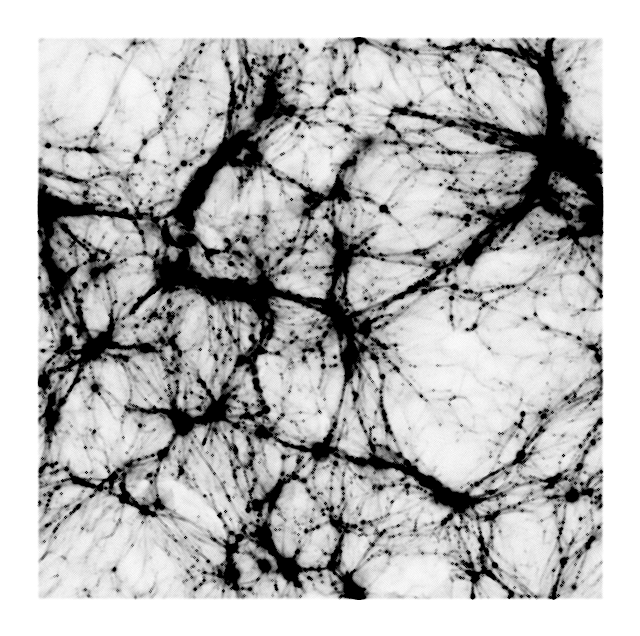

In [7]:
import matplotlib.pyplot as plt

min_z = 50000
max_z = 60000

slice_mask = (gas_data['Coordinates'][:, 2] >= min_z) & (gas_data['Coordinates'][:, 2] < max_z)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(gas_data['Coordinates'][slice_mask, 0], gas_data['Coordinates'][slice_mask, 1], s=0.001, c='k', alpha=0.1)
ax.set_axis_off()
fig.show()

We can see the **cosmic web**! But the dense parts are saturated because there are too many particles close to each other. We can fix this in few ways:
* play with point size and transparency
* make the slice thinner
* change how we plot this
Let's do the last

/tmp/ipykernel_179137/3335449193.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


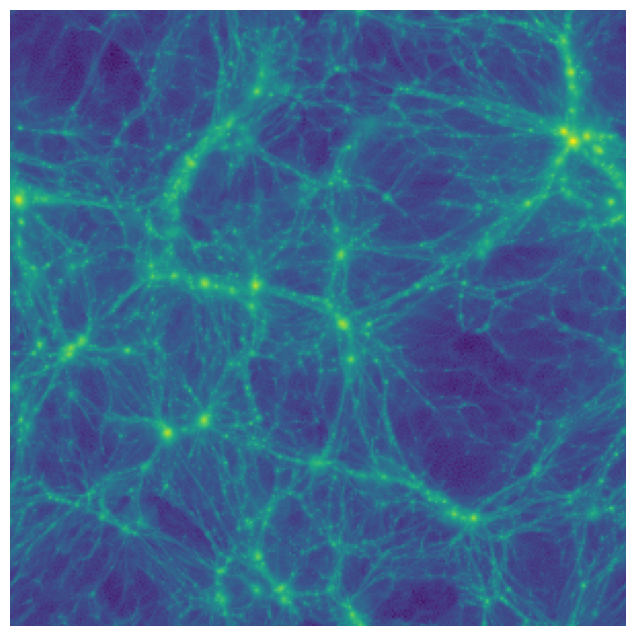

In [ ]:
import matplotlib.pyplot as plt

min_z = 50000
max_z = 60000

slice_mask = (gas_data['Coordinates'][:, 2] >= min_z) & (gas_data['Coordinates'][:, 2] < max_z)

with h5py.File('tng100-3/output/snapdir_098/snap_098.0.hdf5', 'r') as snapfile:
    Lbox = snapfile['Header'].attrs['BoxSize']


fig, ax = plt.subplots(figsize=(8, 8))
h2d, _, _ = np.histogram2d(gas_data['Coordinates'][slice_mask, 0], gas_data['Coordinates'][slice_mask, 1], bins=100)
ax.imshow(np.log10(h2d.T + 1), origin='lower', cmap='viridis', extent=(0, Lbox, 0, Lbox))
ax.set_axis_off()
fig.show()

Now the color shows the gas density! We can see that there are clumps of matter (in yellow) at the nodes of this web. These are the haloes we were talking about earlier. To convince ourselves, let's mark them

In [ ]:
!h5ls tng100-3/output/snapdir_098/snap_098.0.hdf5/PartType0

Coordinates              Dataset {12687804, 3}
Density                  Dataset {12687804}
ElectronAbundance        Dataset {12687804}
GFM_Metallicity          Dataset {12687804}
InternalEnergy           Dataset {12687804}
InternalEnergyOld        Dataset {12687804}
Masses                   Dataset {12687804}
ParticleIDs              Dataset {12687804}
StarFormationRate        Dataset {12687804}
Velocities               Dataset {12687804, 3}


/tmp/ipykernel_177618/548543605.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


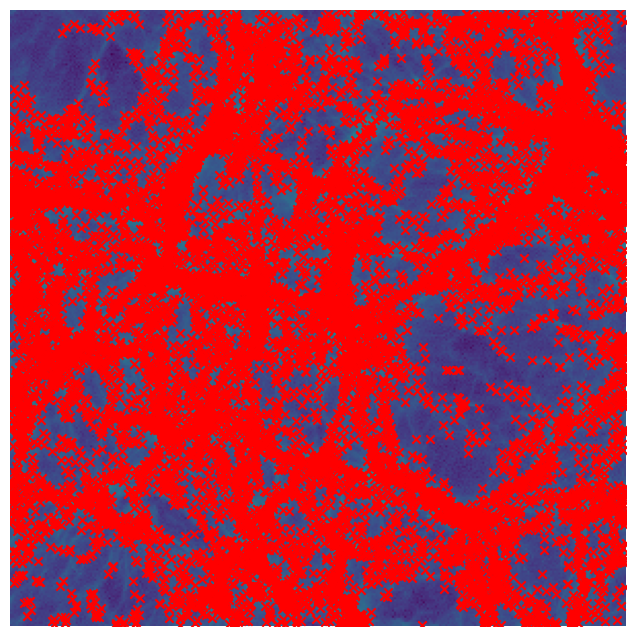

In [ ]:
group_data = il.groupcat.loadHalos('tng100-3/output', 98, fields=['GroupPos', 'Group_M_Mean200'])
slice_mask_groups = (group_data['GroupPos'][:, 2] >= min_z) & (group_data['GroupPos'][:, 2] < max_z)


fig, ax = plt.subplots(figsize=(8, 8))
h2d, _, _ = np.histogram2d(gas_data['Coordinates'][slice_mask, 0], gas_data['Coordinates'][slice_mask, 1], bins=100)
ax.imshow(np.log10(h2d.T + 1), origin='lower', cmap='viridis', extent=(0, Lbox, 0, Lbox))

ax.scatter(group_data['GroupPos'][slice_mask_groups, 0], group_data['GroupPos'][slice_mask_groups, 1], marker='x', c='r')

ax.set_axis_off()
fig.show()

### Other physical quantities
Using a 2D histogram makes it easy to show different physical quantities. 

/tmp/ipykernel_177618/1447065484.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


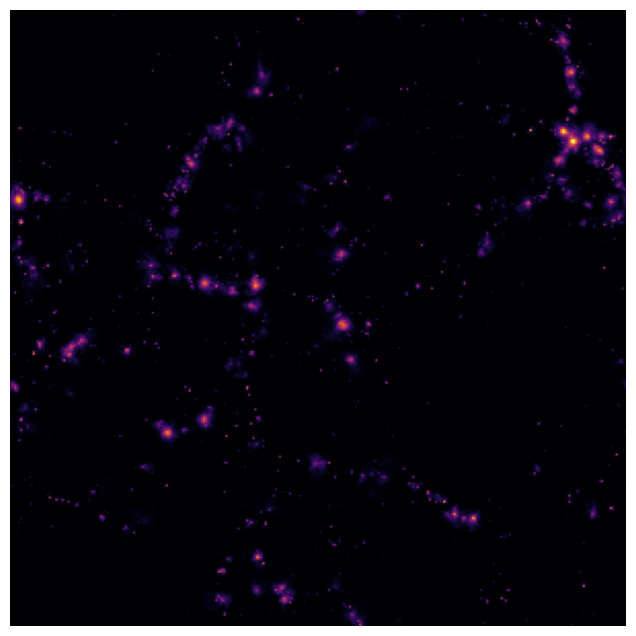

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
h2d, _, _ = np.histogram2d(gas_data['Coordinates'][slice_mask, 0], gas_data['Coordinates'][slice_mask, 1], bins=100, weights=gas_data['GFM_Metallicity'][slice_mask])
ax.imshow(np.log10(h2d.T + 1), origin='lower', cmap='inferno', extent=(0, Lbox, 0, Lbox))
ax.set_axis_off()
fig.show()

### Periodic Boundary Conditions
Cosmological simulations often use PBC. This is the simplest way to simulate an 'infinite' Universe. I practice, it means that if a particle crosses one edge of the simulation, it "enters" from the opposite side.

This also means that we can shift the center of the particle distribution to any point we want. For example:

In [4]:
def shift_center(positions, center):
    new_positions = positions - center + 0.5 * Lbox
    # apply PBC
    new_positions[new_positions < 0    ] += Lbox
    new_positions[new_positions >= Lbox] -= Lbox
    return new_positions

/tmp/ipykernel_179137/1775020739.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


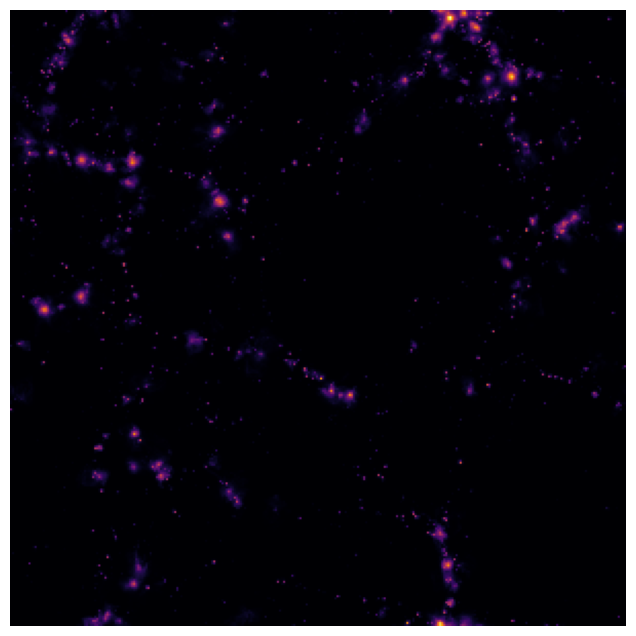

In [ ]:
new_pos = shift_center(gas_data['Coordinates'], np.array([0.7, 0.3, 0.5])*Lbox)

slice_mask = (new_pos[:, 2] >= min_z) & (new_pos[:, 2] < max_z)

fig, ax = plt.subplots(figsize=(8, 8))
h2d, _, _ = np.histogram2d(new_pos[slice_mask, 0], new_pos[slice_mask, 1], bins=100, weights=gas_data['GFM_Metallicity'][slice_mask])
ax.imshow(np.log10(h2d.T + 1), origin='lower', cmap='inferno', extent=(0, Lbox, 0, Lbox))
ax.set_axis_off()
fig.show()

## Individual galaxies
We can try now to visualize individual galaxies. For this, we have to:
* identify where galaxies are, using the group catalogs
* load all and only the particles that belong to a galaxy, using group catalogs + snapshots
* visualize them

We can use illustris_python to do the first two steps for us.

In [32]:
?il.snapshot.loadSubhalo

Signature: il.snapshot.loadSubhalo(basePath, snapNum, id, partType, fields=None)
Docstring:
Load all particles/cells of one type for a specific subhalo
(optionally restricted to a subset fields). 
File:      ~/miniconda3/lib/python3.13/site-packages/illustris_python/snapshot.py
Type:      function

In [287]:
subhalo_id = 949

galaxy_data_gas   = il.snapshot.loadSubhalo('tng100-3/output', 98, subhalo_id, 0, fields=['Coordinates', 'Density', 'Velocities', 'GFM_Metallicity', 'InternalEnergy'])
galaxy_data_stars = il.snapshot.loadSubhalo('tng100-3/output', 98, subhalo_id, 4, fields=['Coordinates', 'GFM_StellarFormationTime'])

In [288]:
#center the galaxy
subhalo_data = il.groupcat.loadSubhalos('tng100-3/output', 98, fields=['SubhaloPos', 'SubhaloMassInRad', 'SubhaloHalfmassRadType'])
galaxy_center = subhalo_data['SubhaloPos'][subhalo_id]
galaxy_data_gas['Coordinates']   = shift_center(galaxy_data_gas['Coordinates'], galaxy_center)
galaxy_data_stars['Coordinates'] = shift_center(galaxy_data_stars['Coordinates'], galaxy_center)

/tmp/ipykernel_179137/3583156996.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


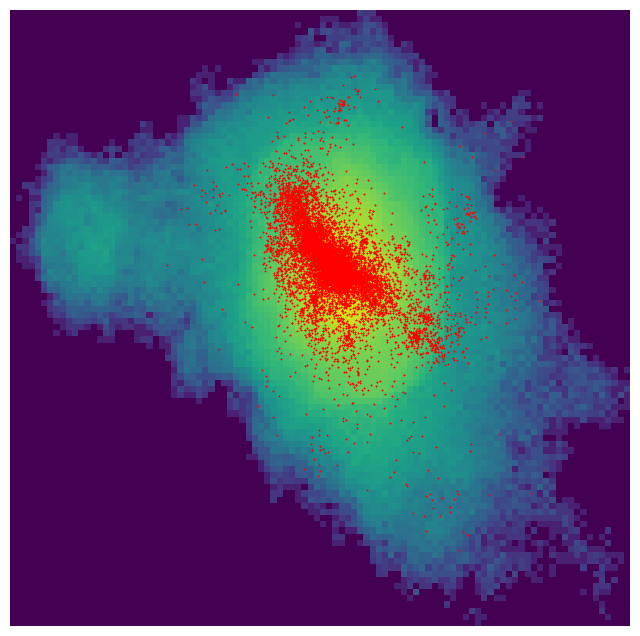

In [289]:
fig, ax = plt.subplots(figsize=(8, 8))
h2d, _, _ = np.histogram2d(galaxy_data_gas['Coordinates'][:, 0], galaxy_data_gas['Coordinates'][:, 1], bins=100)
ax.imshow(np.log10(h2d.T + 1), origin='lower', cmap='viridis', aspect='auto',
          extent=(galaxy_data_gas['Coordinates'][:, 0].min(), galaxy_data_gas['Coordinates'][:, 0].max(), galaxy_data_gas['Coordinates'][:, 1].min(), galaxy_data_gas['Coordinates'][:, 1].max()))
ax.scatter(galaxy_data_stars['Coordinates'][:, 0], galaxy_data_stars['Coordinates'][:, 1], marker='*', s=0.1, c='r')

ax.set_axis_off()
fig.show()

This shows us an important feture of galaxies. Stars are usually much more concentrated than gas! If you are not convinced, try changing the subhalo number and see!

Now let's have a closer look at the stars..

/tmp/ipykernel_179137/975205079.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


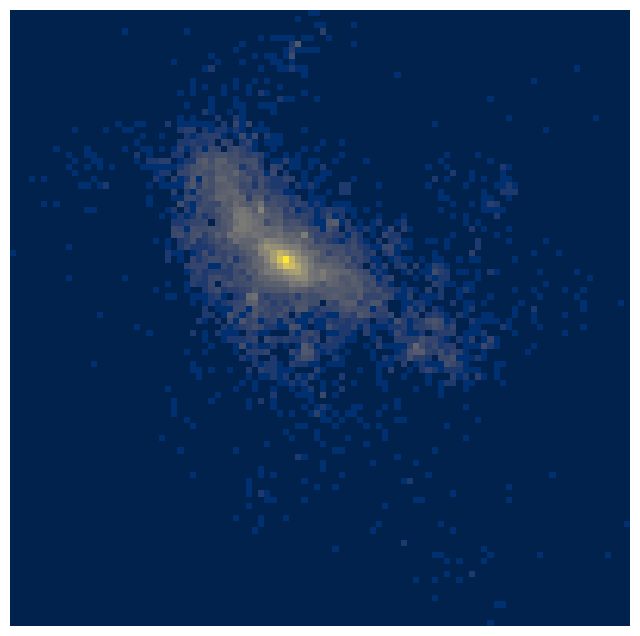

In [290]:
fig, ax = plt.subplots(figsize=(8, 8))

#galaxy_stellar_radius = subhalo_data['SubhaloHalfmassRadType'][subhalo_id, 4]
#selection = np.linalg.norm(galaxy_data_stars['Coordinates'] - np.array([0.5, 0.5, 0.5])*Lbox, axis=1) < 2*galaxy_stellar_radius
selection = np.full_like(galaxy_data_stars['Coordinates'][:, 0], True, dtype=bool) #all particles

h2d, _, _ = np.histogram2d(galaxy_data_stars['Coordinates'][selection, 0], galaxy_data_stars['Coordinates'][selection, 1], bins=100)
ax.imshow(np.log10(h2d.T + 1), origin='lower', cmap='cividis', aspect='auto',
          extent=(galaxy_data_stars['Coordinates'][selection, 0].min(), galaxy_data_stars['Coordinates'][selection, 0].max(), galaxy_data_stars['Coordinates'][selection, 1].min(), galaxy_data_stars['Coordinates'][selection, 1].max()))

ax.set_axis_off()
fig.show()

### hot vs cold gas

In [291]:
def computeParticlesTemperature(u, UnitVelocity_in_cm_per_s = 1e5, MeanMolecularWeight = 1, gamma = 5/3):
    """
    compute the temperature of the (gas) particles from their internal energy

    Parameters
    ----------

    u : numpy.array of float
        internal energy of the particles (as read from GADGET file). shape=(Npart)

    Returns
    -------
    temp : numpy.array of float
           temperature of the particles
    """

    BOLTZMANN = 1.3806e-16
    # units of u are energy/mass = (mass*length2/time2)/mass = (mass*length2/(length/velocity)2)/mass = velocity2
    PROTONMASS = 1.6726e-24  # g
    temp = MeanMolecularWeight*PROTONMASS/BOLTZMANN * (gamma-1) * u * UnitVelocity_in_cm_per_s**2

    return temp


In [292]:
galaxy_data_gas['Temperature'] = computeParticlesTemperature(galaxy_data_gas['InternalEnergy'])

/tmp/ipykernel_179137/45259875.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


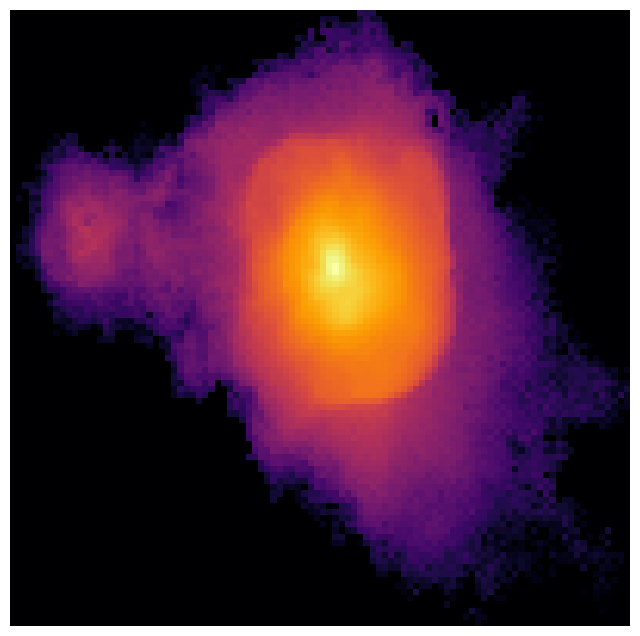

In [293]:
fig, ax = plt.subplots(figsize=(8, 8))
h2d, _, _ = np.histogram2d(galaxy_data_gas['Coordinates'][:, 0], galaxy_data_gas['Coordinates'][:, 1], bins=100, weights=galaxy_data_gas['Density']*galaxy_data_gas['Temperature'])
ax.imshow(np.log10(h2d.T + 1), origin='lower', cmap='inferno', aspect='auto',
          extent=(galaxy_data_gas['Coordinates'][:, 0].min(), galaxy_data_gas['Coordinates'][:, 0].max(), galaxy_data_gas['Coordinates'][:, 1].min(), galaxy_data_gas['Coordinates'][:, 1].max()))

ax.set_axis_off()
fig.show()

/tmp/ipykernel_179137/2616728994.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


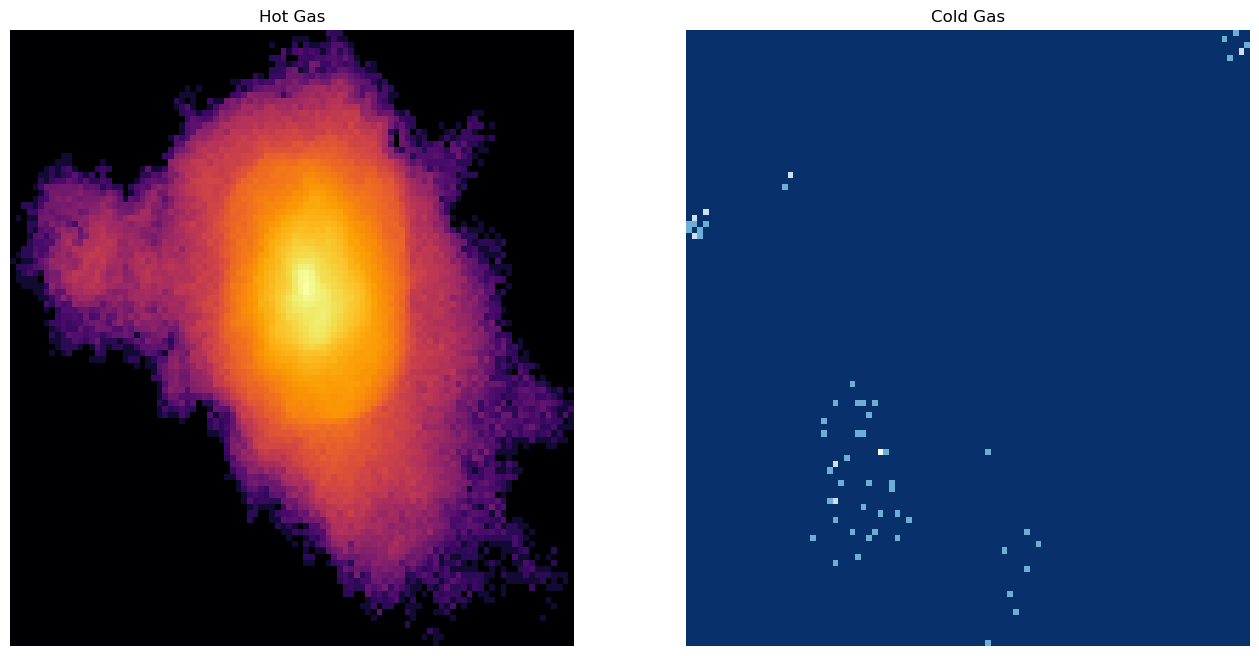

In [294]:
fig, ax = plt.subplots(1,2,figsize=(16, 8))

hot_gas_mask = galaxy_data_gas['Temperature'] > 1e7
cold_gas_mask = galaxy_data_gas['Temperature'] < 1e6

h2d, _, _ = np.histogram2d(galaxy_data_gas['Coordinates'][hot_gas_mask, 0], galaxy_data_gas['Coordinates'][hot_gas_mask, 1], bins=100)
ax[0].imshow(np.log10(h2d.T + 1), origin='lower', cmap='inferno', aspect='auto',
          extent=(galaxy_data_gas['Coordinates'][:, 0].min(), galaxy_data_gas['Coordinates'][:, 0].max(), galaxy_data_gas['Coordinates'][:, 1].min(), galaxy_data_gas['Coordinates'][:, 1].max()))

ax[0].set_title('Hot Gas')
ax[0].set_axis_off()

h2d, _, _ = np.histogram2d(galaxy_data_gas['Coordinates'][cold_gas_mask, 0], galaxy_data_gas['Coordinates'][cold_gas_mask, 1], bins=100)
ax[1].imshow(np.log10(h2d.T + 1), origin='lower', cmap='Blues_r', aspect='auto',
          extent=(galaxy_data_gas['Coordinates'][:, 0].min(), galaxy_data_gas['Coordinates'][:, 0].max(), galaxy_data_gas['Coordinates'][:, 1].min(), galaxy_data_gas['Coordinates'][:, 1].max()))

ax[1].set_title('Cold Gas')
ax[1].set_axis_off()
fig.show()

# Step 3: Phase-space diagram

In [ ]:
gas_data = il.snapshot.loadSubset('tng100-3/output', 98, 0, fields=['Density', 'InternalEnergy'])

In [ ]:
gas_data['Temperature'] = computeParticlesTemperature(gas_data['InternalEnergy'])

/tmp/ipykernel_177618/3106807742.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


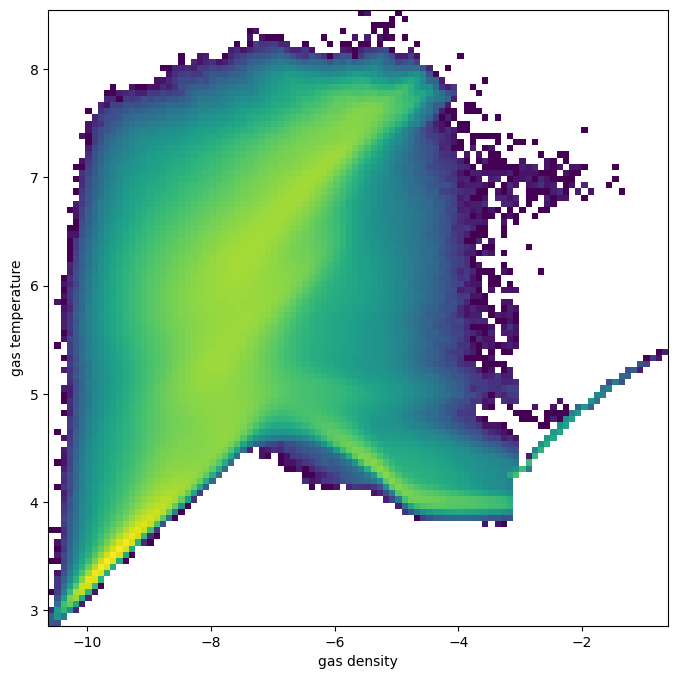

In [ ]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(figsize=(8, 8))
ax.hist2d(np.log10(gas_data['Density']), np.log10(gas_data['Temperature']), norm=LogNorm(), bins=100, cmap='viridis')

ax.set_xlabel('gas density')
ax.set_ylabel('gas temperature')

fig.show()

# Step 4: Halo mass function
This is a basic ...

# Step 5: Stellar-to-halo mass relation

# Step 6: ???